# Processing neuronal spikes

Action potentials and extracellular electrodes
Spikes reflect highly local activity, can be separated into MUA and SUA
Influence of topography and local heterogeneity in coding on decoding from spikes

Loading in binary data

Common average referencing, filtering, peak detection
Waveform sorting
Waveform quality metrics - firing rate, ISI violations, waveform signal to noise, presence ratio, amplitude cutoff, 

Introduction of visual coding dataset from Allen Institute
Loading spike data from Allen Institute

Binning spike times, stimulus-triggered histogram.

In [1]:
import os
import sys
sys.path.append('..')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, freqz, filtfilt, find_peaks
from scipy.ndimage import gaussian_filter1d
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from source.utils import zscore
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
np.random.seed(47)


/Users/drewheadley/anaconda3/envs/decode_brain/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Action potentials and extracellular spikes
In Week 1 we simulated a sheet of neurons and then moved a simulated electrode closer and closer to them. Recall that neurons receive relatively slow (50 ms long) synaptic inputs that occasional trigger them to fire an action potential. Action potentials are large, brief (~1ms), positive going swings of the membrane voltage. These are conducted down the neuron's axon towards its target, eliciting synaptic responses in their targets. All these events can be detected by electrodes placed near the neurons, with the distance of the electrode from the neuron strongly impacting which are seen.

![Extracellular field with distance](./images/simulated_fields.png)

When the electrode was at 2 cm we only saw a weak slow signal that reflected the shared excitability of all the neurons and their correlated synaptic drive. This signal resembles what is seen with EEG electrodes placed on the scalp. As we moved the electrode closer, to be 0.5 mm from the neurons as is the case with ECoG electrodes, the signal got stronger and high frequency buzzing appeared that reflected the activity of small populations of neurons. Finally, driving our electrode to within 10 um of a single neuron (less than the thickness of a human hair), we could see the extracellular reflection of its action potential towering over the slow shared synaptic signals. This signal is what is seen when small tipped electrodes are inserted into the brain near neurons. The extracellular action potentials are referred to as *spikes* and the slow activity resembling the ECoG signal is generally referred to as the *local field potential* (LFP). Because the notion that spikes arise from extracellular action potentials is often an inference - we don't independently confirm it with another measurement modality - we refer to the source of a spike as a *unit* and not a neuron. When a particular collection of spikes we record are thought to arise from just a single neuron they are called *single unit activity*. If we think that multiple neurons contribute to the spikes, then they are called *multiunit activity*.

Over the years, a variety of electrodes have been used to record spikes. The general principle is that the recording site is small and lies somewhere along a thin shaft. The size of the recording site can vary, but generally its diameter is on the order of a single neuron, ~15 um. Electrodes originally tended to be sharpened tungsten needles with insulation within a micron of the tip. With these one could easily record single unit activity. To make these, a rod of tungsten is etched to a point by repeatedly dipping it in acid, then coated with a varnish to insulate it, followed by placement in a sparking chamber to burn off a microscopic portion of insulation at the tip.
Microwires can be used as well. These are easier to manufacture, you just buy the wire, which ranges from 10 to 50 microns in diameter, and then bundle them into an array with the desired configuration. Because of their large recording surface areas, one typically detects spikes arising from many units that are difficult to separate. 
To allow for better separation of units, in the late 1970s and early 80s workers began to bundle their microwires closely together into stereotrodes and tetrodes by twisting them together. This allowed for the detection of many units, but each with its own distinct waveform profile across the various recording sites, so they could be sorted into single units.
Silicon probes were developed first in the late 1960s, but only became readily available in the early 2000s. Allows for groups of recording sites to be staggered at regular intervals and with arbitrary site geometry. 

![Examples of spike recording electrodes](./images/ClassicElectrodeExamples.png)

The reviewed above have primarily been used in animal studies, but there are design that are intended for human use. The current favorite is a splayed bundle of microwires that emerges from a shank containing large electrodes capable of recording signals akin to the ECoG. The shank is inserted deep into the brain to access structures that are not on the cortical surface (typically the hippocampus or amygdala in patients undergoing treatment for medial temoral lobe epilepsy). Another design, the Utah Array (designed at the University of Utah), is an array of sharpened silicon electrodes that is pushed into the cortical surface, providing unit activity from neurons immediately under the array. A drawback to this design is that the pin cushion shape of the array causes extensive damage and the sharp electrodes have poor long term performance when recording single unit activity. To overcome those challenges, Neuralink has designed a soft electrode array where the recording sites are spaced along its length. These are then inserted rapidly one at a time into the brain using a robotic device and then left to 'float' in the brain. This minimizes mechanical damage caused by the insertion and chronic damage since the electrodes will move with the brain. It recently won FDA approval for testing in humans (but without some controversy!). Lastly, scientists have adapted the same chip fabrication techology that makes image sensors in cell phones to create high density electrode arrays with thousands of recording sites. These probes include all the amplification, filtering, and digization on the chip, meaning that only a single two-wire cable is required to stream the data to a computer. These have begun to be used intraoperatively to decode human brain activity (e.g. [speech decoding](https://www.nature.com/articles/s41586-023-06839-2)).

![Recent examples of spike recording electrodes](./images/RecentElectrodeExamples.png)

## What can spikes tell us?
Spikes give us two distinct kinds of information: their waveforms and the times they occur. 

Spike waveforms are determined by the shape of the neuron, the distribution of currents moving across its membrane that create the action potential, and the relative location of the electrode. These factors can interact to create a variety of spike waveforms depending. This is demonstrated when we consider the amplitude of the waveform for neurons with different shapes. For this analysis to work, we have to bring another fact to bear: that the net transmembrane current across an entire neuron is zero. This comes from Kirchoff’s current law. What this means is that an action potential at the soma, which is associated with an inward current, will have a corresponding outward current in the distal dendrites. Likewise, a synaptic inward current in the dendrites will produce an outward current at the cell body. These ‘return’ currents are passive and summated with the active currents present in the membrane.

EXPLAIN AND SHOW FIGURE OF SIMULTANEOUS INTRACELLULAR/EXTRACELLULAR RECORDING

![Einevoll et al 2013 figure]()

Given all that, we can divide neurons into two types. The first is called a closed source, and it applies to cells which are small and multipolar (e.g. stellate). The currents in the sphere of dendrites surrounding the soma will have an opposite sign to the current at the soma, effectively acting as a shield and reducing the strength of the field we can detect.
The second is called an open source, and it applies to cells which are elongated with only a few principal dendritic branches (e.g. pyramidal). The inward and outward pair of currents separated by some distance acts as dipole, which enhances the strength of the field one detects.

![Linden et al. 2011 figure]()

Cortical pyramidal neurons, the principal excitatory neuron in the cortex, tend to be open sources. They produce large spike waveforms that are readily detected. Some times of cortical inhibitory interneurons, which regulate the excitability of pyramidal neurons, have a closed source geometry and usually produce smaller spike waveforms.

Despite this, in general the smaller a spike waveform's amplitude is, the farther that neuron is from the electrode. When multiple electrodes are place in close proximity to the neuron, so each picks up its spiking activity, they will each have a different spike waveform. For instance, ...

![Gold et al. figure]()

This can be leveraged to better isolate single units from multiunit recordings.

## Spike sorting
Traditionally spike sorting was divided into four steps:

1. **Signal preprocessing:** Raw extracellular recordings contain low frequency (less than ~200 Hz) activity 'local field potentials', higher frequency noise (greater than ~6 kHz), and action potential related signals (between 300 and 6000Hz). Removal of shared noise or correlations across electrodes can also be performed.
2. **Detection of spiking events:** Spiking events are detected as deviations from the recording 'noise' and snippets of waveforms around these points are taken for later clustering. Several different detection strategies can be used, with some differences between detection on single and multi-electrode recordings.
3. **Dimensionality reduction of spike waveforms:** We want to identify features in the spike waveforms that can be used for sorting them. One can use hand-crafted features (e.g. amplitude, spike-width), or automated approaches to derive features. These feature spaces can be thought of as dimensionality reduction, which enhances our ability to visualize clusters of similar spike waveforms and makes the subsequent clustering process less computationally expensive.
4. **Clustering of spike groups:** Often the feature space will contain several groupings of spike waveforms. One can place the borders between these manually, or use unsupervised clustering algorithms.

We will consider each of these steps. At each stage, multiple options will be given so if you want you can create your own simple spike sorting algorithm!

### Loading recording data
Extracellular field potential (voltage) recordings are often saved as binary files. Binary files are a list of numbers with a length equal to the *number of channels* **X** *number of time samples*. Each number has a format, most often a signed 16 bit integer for neural recordings. Information about the number of channels, time points, and data format are stored in a separate file (sometimes referred to as a meta file because it has meta information, i.e. information about your information). Most of the time, data is ordered first by channel, then by time, resulting in a format of: 
ch1_t1, ch2_t1, ch3_t1, ..., chN_t1, ch1_t2, ch2_t2, ch3_t2, ..., chN_tM

In total, we have *N* channels (ch) and *M* time points (t). If each number is a signed 16 bit integer, than each is 2 bytes, which means the total file size will be *N* **X** *M* **X** 2. I have included some sample data to practice sorting on. Let's see what its file size is.

In [2]:
# Get the number of bytes of the binary file
bin_path = '../data/spike_signals/test.bin'
bin_sz = os.stat(bin_path)
print("The binary file is {x} bytes in length".format(x=bin_sz.st_size))

The binary file is 31200000 bytes in length


This file is a snippet of data from a much longer Neuropixel probe recording. I know that I selected 8 adjacent channels on the probe, but I don't remember how many time points there were. To get the number of time points, we can take the number of bytes and divide by *N channels* **X** *bytes per sample*. We have 8 channels and each sample has 2 bytes.

In [3]:
# Calculate number of time points
chan_num = 8
tpt_num = bin_sz.st_size/(chan_num*2)
print("The number of time points is {x}".format(x=tpt_num))
tpt_num = int(tpt_num)

The number of time points is 1950000.0


We have 1,500,001 time points. You want this to be a whole number, since we cannot have fractional data points. If we do not get a whole number from this calculation, then either we are wrong about the number of channels or the number of bytes per sample.

Dividing the number of samples by the sample rate per second we get duration of our recording in seconds.

In [4]:
# Determine how long our recording is
samp_rate = 30000 # Hz, samples per second
print("The recording duration is {:.2f} seconds".format(tpt_num/samp_rate))

The recording duration is 65.00 seconds


Now let's read in the data. Since our file is small, only 24 MB, we will read it all into our workspace as a numpy array. When dealing with *real* data that can be tens to hundreds of GB in size you will use memory mapping or chunking. We won't worry about that here.

In [5]:
# Read in our binary data into a numpy array
rec_raw = np.fromfile(bin_path,np.int16)

# Rearrange the data from a list to a matrix, with time points along the rows and channels along the columns
rec_raw = np.reshape(rec_raw,(int(tpt_num),chan_num))

Now we will plot the data to make sure everything is formatted correctly. It is best to only plot a short segment of time, a few 10s of milliseconds, since plotting the entire recording would take a while and be difficult to visualize individual spikes.

<Axes: xlabel='Time (samples)', ylabel='Channel'>

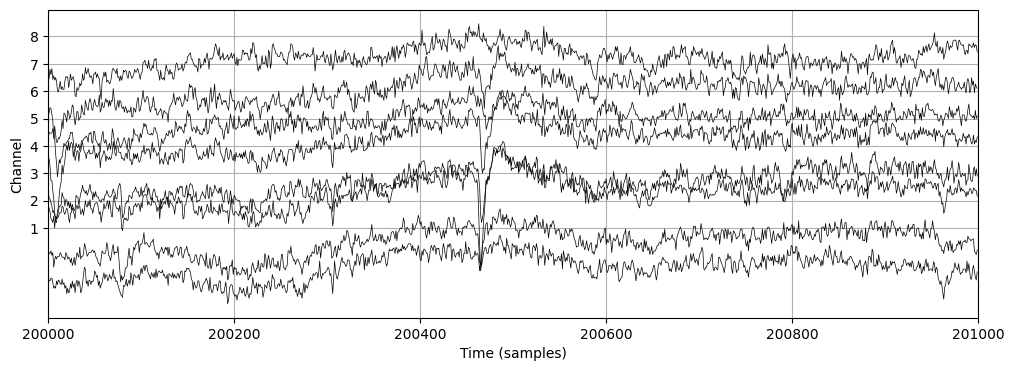

In [6]:
# defining a plotting function since we will do a lot of plotting
def SnipPlot(sig, win=[200000, 201000], x_offset=0, ax=None, **kwargs):
    """
    Plots a snippet of the recording

    Parameters
    ----------
    sig : array
        The signal to plot, with time along the rows and channels along the columns
    win : list, optional
        The window to plot, in samples. Format: [start, end]
    x_offset : float, optional
        The offset to add to the x-axis
    ax : matplotlib axis, optional
        The axis to plot on
    kwargs : dict, optional
        Keyword arguments to pass to matplotlib

    Returns
    -------
    ax : matplotlib axis
        The axis that was plotted on
    """

    if ax is None:
        ax = plt.gca()

    chan_num = sig.shape[1]
    samp_vals = np.arange(win[0],win[1])
    ax.plot(samp_vals+x_offset, sig[win[0]:win[1],:]+np.arange(0,chan_num)*30, linewidth=0.5, **kwargs)
    ax.set_xlabel('Time (samples)')
    ax.set_ylabel('Channel')
    ax.set_xlim(win)

    # Set the yticks to be at the center of each channel
    ax.set_yticks(np.arange(0,chan_num)*30)
    ax.set_yticklabels(np.arange(0,chan_num)+1)
    ax.grid(True)
    return ax

fig, ax = plt.subplots(1,1,figsize=(12,4))
SnipPlot(rec_raw, ax=ax, color='k')

DESCRIBE THE SIGNAL HERE, POINT OUT THE SPIKES, NOISE, SLOW FLUCTUATIONS.

### Signal preprocessing
The raw signal has several problems. Many of these are similar to the problems we discussed with EEG signals. First, each channel has a different voltage offset from 0 (known as a DC component). This is evident in the overlapping of some of the traces even though they are separated in the plot. Second, there are slow fluctuations in the signal that are comparable in amplitude in the spikes and prohibit the use of a fixed threshold for spike detection. Last, noise that is common to all channels should be removed.

#### Removal of DC offset

Each channel has a slight voltage offset from 0. This can be removed by subtracting the median voltage from each channel. Alternatively, the bandpass filter we will do in the next step also gets rid of it, but it can produce distortions at the beginning and end of the time series when the signal is strongly offset from zero. Thus, you might just want to remove the DC offset first.

Text(0.5, 1.0, 'DC offset removed recording data compared with raw signal')

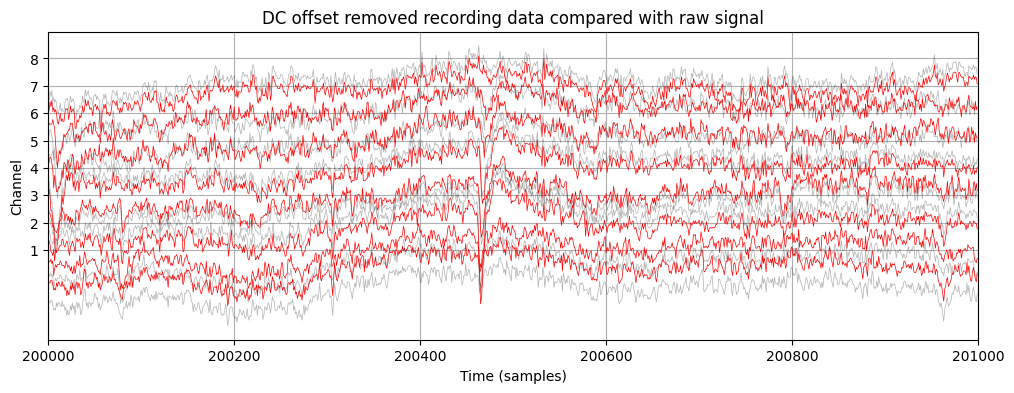

In [7]:
# just removed the DC offset from the raw signal
rec_nodc = rec_raw - np.median(rec_raw,axis=0).reshape((1,-1))

fig, ax = plt.subplots(1,1,figsize=(12,4))
SnipPlot(rec_raw, ax=ax, color='k', alpha=0.3, label='Raw signal')
SnipPlot(rec_nodc, ax=ax, color='r', label='DC offset removed signal')
ax.set_title('DC offset removed recording data compared with raw signal')

Now our signals that were originally not evenly spaced apart (gray lines) due to their DC offsets, are evenly separated (red lines).

#### Filtering in the spikes frequency band

After removing the DC offset there is still a slow fluctuation in the voltage that is comparable in strength to the amplitude of the spikes. Since we will eventually detect spikes using a fixed threshold throughout the recording, this slow fluctuation may cause our spike detection to fail. Moreover, there is a lot of high frequency jitter in the voltage trace that is not spike related and partly noise. This could cause spurious spike detections or impair our ability to sort later on. To remove both these signals, we can use a bandpass filter, which keeps signals that fall inside a desired frequency range. For spikes, that range is usually between 300 and 3000 Hz.

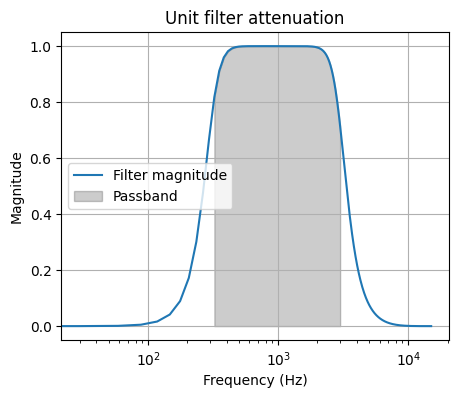

In [8]:
# Define frequency passband in Hz
f_order = 4
f_pass = [300, 3000]

# Create filter and display its properties
b, a = butter(f_order, f_pass, 'bandpass', fs=samp_rate)
w, h = freqz(b,a,fs=samp_rate)
fig, ax = plt.subplots(1,1,figsize=(5,4))
ax.plot(w,np.abs(h), label='Filter magnitude')
ax.set_xscale('log')
ax.grid(True)
ax.set_title('Unit filter attenuation')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Magnitude')
# add transparent box to show passband
ax.fill_between(w,0,np.abs(h),where=(w>=f_pass[0])&(w<=f_pass[1]),color='k',alpha=0.2, label='Passband')
ax.legend()

Now that we have the filter with the desired frequency range, lets apply it to our data.

<Axes: xlabel='Time (samples)', ylabel='Channel'>

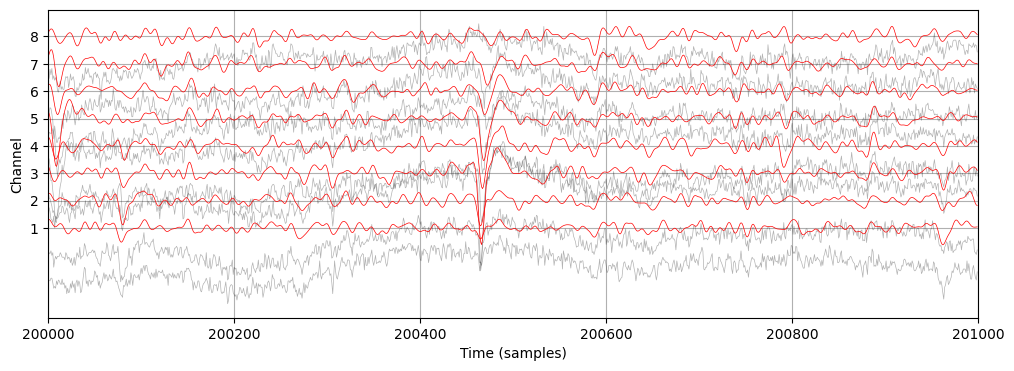

In [9]:
# filter the signals to remove the DC, low frequency LFP, and high frequency noise
rec_filt = filtfilt(b,a,rec_raw.T).T

# plot filtered signal over DC offset removed signal
fig, ax = plt.subplots(1,1,figsize=(12,4))
SnipPlot(rec_raw, color='k', alpha=0.3, label='Raw signal')
SnipPlot(rec_filt, color='r', label='Filtered signal')

Filtering has removed the low frequency activity and smoothed the traces, which will make the signals easier to analyze in subsequent steps.

#### Common average referencing

A general rule of thumb in spike sorting is that the spikes arising from single neurons will be spatially confined to a small area, usually less than 100 microns. This is because the spike reflects the currents flowing across the cell membrane, and the voltage that generates decays with distance. Thus, electrodes closer to the cell body pick up a stronger signal than those far away. By contrast, noise signals that arise from sources outside the brain will by picked up similarly by all electrodes. Thus, if we remove a signal shared across all electrodes we should be able to eliminate noise while preserving spiking activity. This process is referred to as common average referencing or CAR for short.

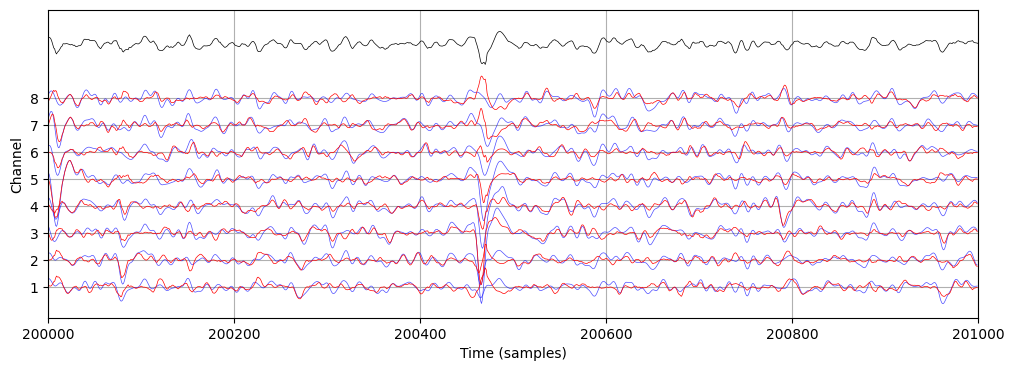

In [97]:
# remove median (common) signal across electrodes
car =  np.median(rec_filt,axis=1).reshape((-1,1))
rec_car = rec_filt - car

# plot filtered signal with common average reference removed
fig, ax = plt.subplots(1,1,figsize=(12,4))
SnipPlot(rec_filt, ax=ax, color='b', alpha=0.7)
SnipPlot(rec_car, ax=ax, color='r')
ax.plot(car+270, color='k', linewidth=0.5, label='Median signal')

The the above plot the blue lines are the original signals, while the red have had the CAR removed. The black line at the top is the CAR signal. CAR removes the signal that is common across all electrodes. Oberving the background periods where no spiking is present, we can see that the jitter in the trace has been reduced. The original trace shows larger background activity than trace with CAR removed. 

If only a few closely spaced electrodes are recorded from, than a spike that appears on all of them will be picked up by the CAR signal and cause a distortion of the spike waveform. Here we can see that occuring with the large spike in the middle of our plot. Spikes that only occur on a few electrodes do not suffer from this problem because the median of the signal across all electrodes will be less sensitive to the deflection they cause. In general, if a given spike waveform occupies more than half of the electrodes, then it will probably contribute to the CAR. Given this, it is best if CAR is used with many electrodes that are close enough together to record the same noise signal, but not so close that they all pick up activity from the same neurons.

### Spike detection

Once the recording has been processed to accenuate spikes, we need to detect them. Several different approaches have been proposed for doing this. This depends on whether you have just one or multiple electrodes, how close those electrodes are to each other, whether you know their spatial arrangement, how you define the noise level, etc. 

#### Simple thresold detection

The easiest way to detect spikes is to set a threshold on each electrode and then pool these detections together.

In [11]:
# define peak conditions
z_thresh = 2 # minimum peak height
min_dist = 30 # minimum distance between peaks, at 30kHz sample rate this is 1ms

# z-score transform each channel so that the same threshold can be used across all of them
rec_z = zscore(rec_car,axis=0)

# identify peaks on each channel that exceed the z threshold
spks_all = []
for ch_sig in np.hsplit(rec_z, chan_num):
    spks_all.append(find_peaks(np.abs(ch_sig.squeeze()), 
                               distance=min_dist, height=z_thresh)[0])

We can check our spike detection performance by plotting spike times on top of recordings.

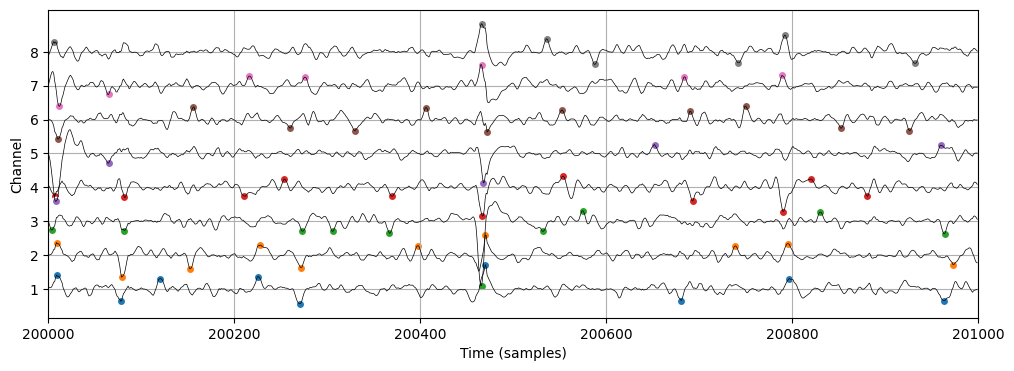

In [12]:
def SnipSpksPlot(sig,spks, **kwargs):
    ax = SnipPlot(sig, **kwargs)
    win = ax.get_xlim()
    for chan,x in enumerate(spks):
        spk_sub = x[np.where((x>=win[0])&(x<=win[1]))]
        peak_vals = sig[spk_sub,chan] + chan*30
        ax.scatter(spk_sub,peak_vals, edgecolors='w')

fig, ax = plt.subplots(1,1,figsize=(12,4))
SnipSpksPlot(rec_car,spks_all, color='k')

Since this is a multichannel recording, we want to combine the spike times across all electrodes. The simplest way to do this is to pool them all together and remove duplicates. This works here because generally if a spike is detected on multiple channels it reflects the same neuron. However, if we were using a larger array of electrodes where difference units could be detected simultaneously then this approach would not work (a problem known as 'shadowing').

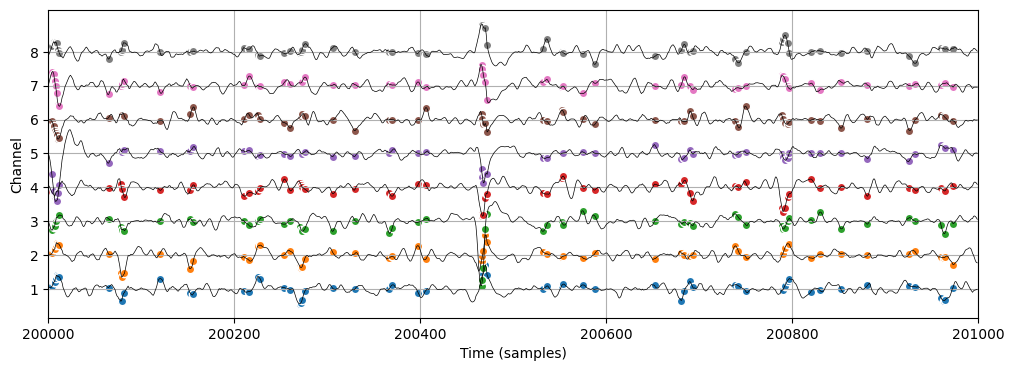

In [13]:
# pool spike times and remove duplicates
spks_pooled = np.unique(np.hstack(spks_all))

# plot again to verify that merging was successful
fig, ax = plt.subplots(1,1,figsize=(12,4))
SnipSpksPlot(rec_car,[spks_pooled]*chan_num, color='k')

Uh, oh! It looks like we are getting multiple detections for the same spikes. You can see this best with the prominent spike around time step 700.

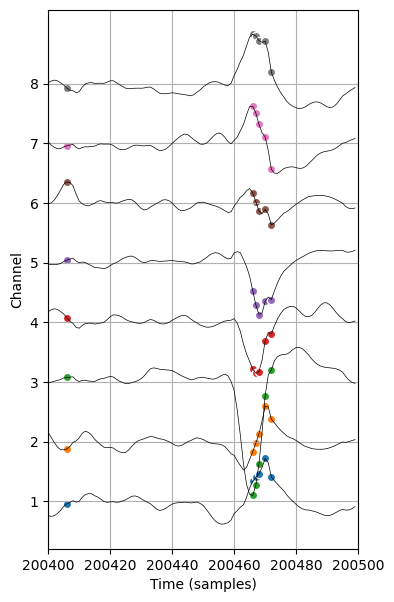

In [14]:
fig, ax = plt.subplots(1,1,figsize=(4,7))
spk_win = [200400, 200500]
SnipSpksPlot(rec_car, [spks_pooled]*chan_num, win=spk_win, ax=ax, color='k')

We can deal with this by identifying the spike time that has the strongest amplitude, and removing the other spike times that are within the minimum spacing we defined already. The quick-n-dirty algorithm below does this.

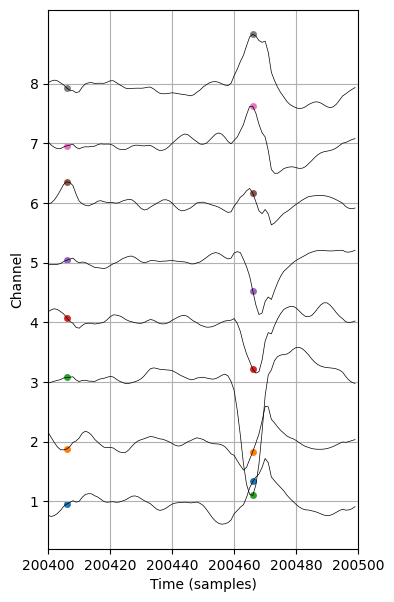

In [15]:
# For each spike time, get its peak amplitude across all channels
spks_amp = np.abs(rec_z[spks_pooled,:]).max(1)
spks_num = len(spks_pooled)

# Here is a simple algorithm to remove redundant spikes
spks_keep = [False]*spks_num # list of spikes to keep, initially we don't keep any
ind = 0
while (ind < spks_num): # step through our spike list
    spk_curr = spks_pooled[ind] # get current spike index
    spk_near_inds = np.where(np.abs(spks_pooled[ind:]-spk_curr)<=(min_dist/2))[0] # find spikes within half original min distance
    max_ind = np.argmax(spks_amp[ind + np.arange(spk_near_inds.size)]) # get index of nearby spike with largest amplitude
    spks_keep[ind+max_ind] = True # keep the spike
    if spk_near_inds.size > 1:
        ind += spk_near_inds.size+1 # move along to next spike that is not redundant
    else:
        ind += 1

# Get the final list of spikes with redundant ones removed
spks_simp = spks_pooled[spks_keep]

# plot again to verify that redundant spikes were removed and only kept largest amplitude ones
fig, ax = plt.subplots(1,1,figsize=(4,7))
SnipSpksPlot(rec_car,[spks_simp]*chan_num, win=spk_win, ax=ax, color='k')

#### Overall energy across electrodes
Instead of detecting spikes separately on each channel, we could pool the signals together across all channels and detect spikes on this aggregate signal.

<Axes: xlabel='Time (samples)', ylabel='Channel'>

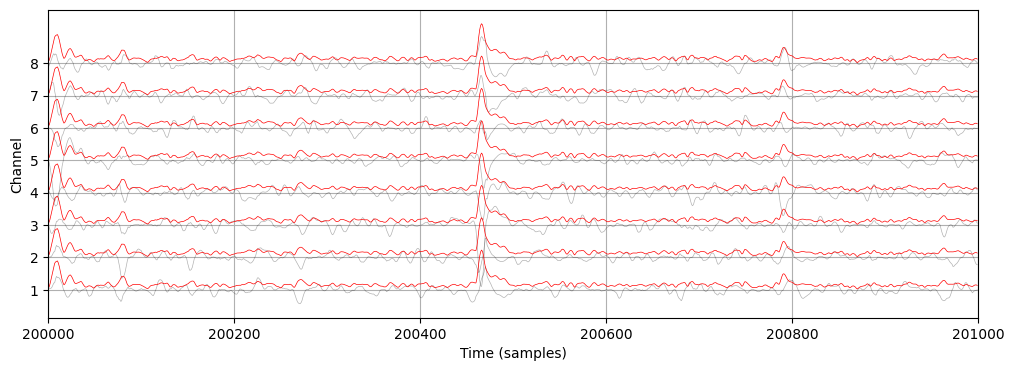

In [16]:
# define peak conditions
z_thresh = 2 # minimum peak height
min_dist = 15 # minimum distance between peaks, at 30kHz sample rate this is 1ms

# z-score transform each channel so it is easier to compare results with simple method
rec_z = zscore(rec_car,axis=0)

# get overall amplitude across electrodes
rec_zn = np.linalg.norm(rec_z,axis=1) # calculates Frobenius norm (essentially euclidian distance of each time point)

# compare the mean signal with those from each channel
fig, ax = plt.subplots(1,1,figsize=(12,4))
SnipPlot(rec_car, ax=ax, color='k', alpha=0.3)
SnipPlot((np.tile(rec_zn.reshape(-1,1),(1,chan_num))*2), ax=ax, color='r')


By detecting spikes on just the single derived norm trace, we eliminate the problem of harmonizing redundant spikes across electrodes.

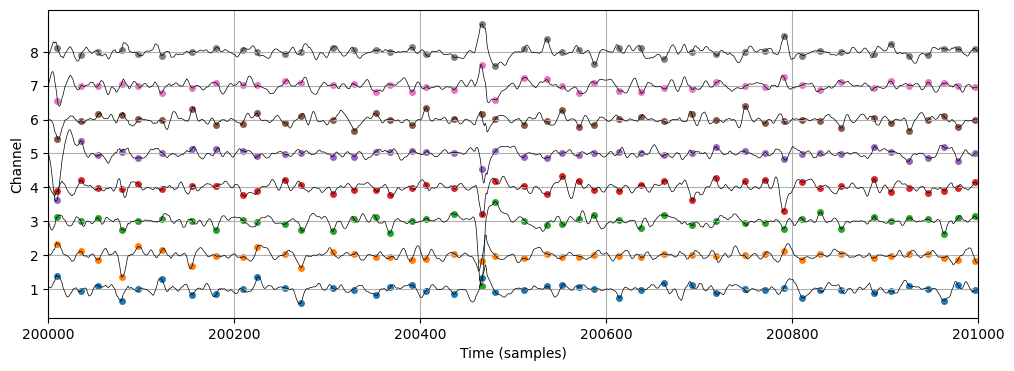

In [17]:
# identify peaks
spks_norm = find_peaks(rec_zn, distance=min_dist, height=z_thresh)[0]

# plot again to verify that redundant spikes were removed and only kept largest amplitude ones
fig, ax = plt.subplots(1,1,figsize=(12,4))
SnipSpksPlot(rec_car,[spks_norm]*chan_num, ax=ax, color='k')

### Dimensionality reduction of spike waveforms

Once we have identified the spikes, we want to assign them to different neurons based on their waveform shape. Each neuron near our electrode will produce a different waveform shape due to its morphology and positiion relative to the array of electrodes. Trying to manually assign each waveform to a particular neuron is impractical, both because of the enormous number of spikes and the difficulty of comparing waveforms across many channels.

In [18]:
# Select spike time source
spks = spks_norm

# Spike waveform extraction parameters
win_start = -15
win_end = 45
win_inds = range(win_start,win_end)
win_num = len(win_inds)

# remove spikes whose waveform window will overlap with the edges of the recording
spks = spks[np.where((spks>(-win_start))&(spks<(tpt_num-win_end)))]

# preallocate waveform array
spks_num = spks.size
waves = np.zeros((spks_num, win_num, chan_num))

# reshape our rec to make waveform extraction simpler
rec = rec_z.T

# Extract spike waveforms 
for ind,spk_curr in enumerate(spks):
    waves[ind,:,:] = rec[:,spk_curr+win_inds].T.reshape((win_num,chan_num))


To make sure our waveforms look right, we will plot a few. Each line is a different spike, with the waveform tiled aross all channels. Thus, the length of the line will be *number of waveform samples* **X** *number of channels*. Here we will just plot two waveforms that are obviously distinct.

Text(0.5, 1.0, 'Two example spike waveforms')

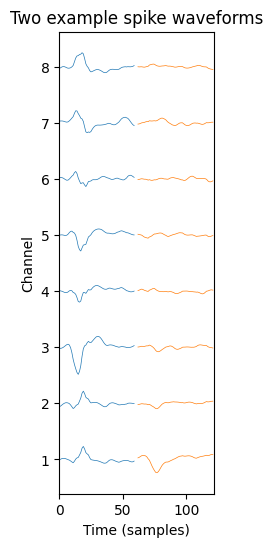

In [161]:
fig, ax = plt.subplots(1,1,figsize=(2,6))
SnipPlot(waves[73,:,:], win=[0,60], ax=ax, color='tab:blue')
SnipPlot(waves[94,:,:], win=[0,60], ax=ax, x_offset=62, color='tab:orange')
ax.grid(False)
ax.set_xlim([0, 122])
ax.set_title('Two example spike waveforms')

As you can see, the waveforms are different from these two units. One of them shows the spike waveform spanning all recording channels, with peaks on each channel. The other is more restricted, with only the bottom 3 channels showing anything resembling a spike waveforms.

There are a few features of the waveform that indicate they arise from an action potential. We will first focus on the channels with the strongest waveform (channel 3 for the first spike and channel 1 for the second), since these are likely closest to the cell body of the neuron where the action potential originates. The spike begins with a negative-going deflection, which reflects the depolarization of the membrane during the initial rising phase of the action potential. During that positive charges rush into the neuron, creating a negative current from the perspective of our electrode that is outside the cell. The negative depolarization lasts for only ~10 samples, or 0.3 ms. It is followed by a postive-going wave (especially in the first spike), which reflects the repolarization of the membrane at the end of the action potential. This pattern of positive, then negative, is typically what is observed for extracellularly detected action potentials. Note that for the first spike many of the electrodes away from the cell body show an initial positive wave. This is an artifact of the CAR removal because we are subtracting a large negative wave from electrodes with a weak negative peak, causing a positive wave to form.

Despite the stereotypy of the spike waveforms shape, they do vary in their amplitude and the particular timing of their postivie and negative phases. These differences arise mostly from the position and geometry of the neuron with respect to the electrode. Since every neuron near our electrode will have a slightly different shape and position with resepct to our electrodes, these differences in the spike waveform across electrodes can act as a finger print to discriminate between them. 

Discriminating between spikes so that we can group them based on the neuron they came from is referred to as spike sorting. Given the number of spikes and channels, it is impractical to try to do this manually. Instead, we will distill the shape of each spike down to just a few features and pass those to an algorithm that will identify clusters in those number.

#### Hand crafted features
There are numerous simple features one can extract from each spike waveform. One is the peak (positive or negative) of the spike wave across channels. More complicated measures would be the duration of the spike, ascending or descending slope, or strength of secondary peaks.

The simplest way to get the waveform peak is to just sample the voltage at each channel at the time the spike was detected. A problem with this approach is that the spike may peak at slightly different times on different electrodes. For this demo, we will neglect this problem.

In [21]:
# extract peak voltages
waves_peak = waves[:,-win_start,:].squeeze()

This gives us as many dimensions as there are channels. If you have more than 3 dimensions, visualization can be tricky. One easy way to visualize a high dimensional space is to create a grid of plots with each showing the data from a different vantage point. A pair plot does this by creating a scatter plot for each pair of dimensions.

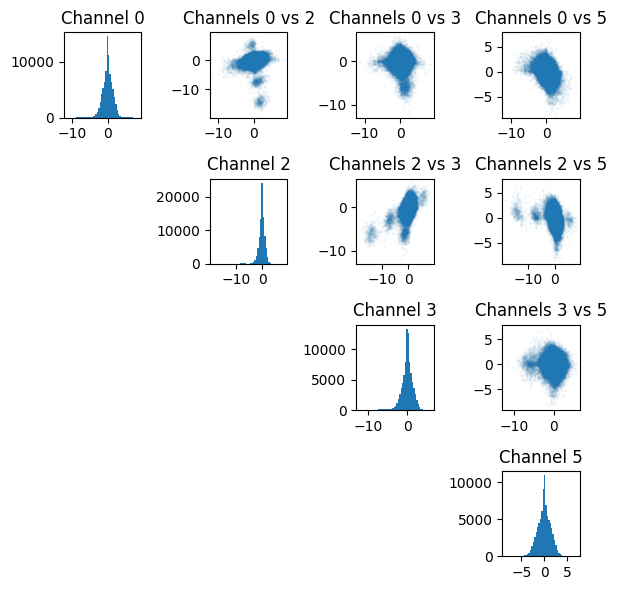

In [22]:
chan_list = [0,2,3,5]
fig, ax = plt.subplots(4,4,figsize=(6,6))
for ind1, chan1 in enumerate(chan_list):
    for ind2, chan2 in enumerate(chan_list):
        if ind1==ind2:
            ax[ind1,ind2].hist(waves_peak[:,chan1], bins=50)
            ax[ind1,ind2].set_title('Channel {x}'.format(x=chan1))
        elif ind1>ind2:
            ax[ind1,ind2].axis('off')
        else:
            ax[ind1,ind2].scatter(waves_peak[:,chan1],waves_peak[:,chan2], alpha=0.1, s=.1)
            ax[ind1,ind2].set_title('Channels {x} vs {y}'.format(x=chan1,y=chan2))

fig.tight_layout()

A few things are apparent from this plot. First, two major clusters, one reflecting positive peaks and the other negative peaks. Second, peak amplitudes tend to be correlated across channels, so if a spike peak is positive on one channel, it will also be positive on another channel. Lastly, some channel pairs show hints of well defined groupings beyond the two major ones (e.g. Ch6/Ch0 pair).

#### Principal components analysis (PCA)

For our hand crafted features we just used the voltage at the peak. However, this doesn't exploit informationa about the entire spike shape. One way to capture this is to identify features across the entire waveform (components) and score each spike based on that component's contribution. PCA does this. We can choose how many components to use, but typically one uses the 3 that explain the most variation across all spike waveforms.

Typically, one would run PCA on each channel separately.

In [23]:
# Set PCA parameters
n_comp = 3

# Create PCA object
pca = PCA(n_components=n_comp)

# Apply PCA to each channel separately
pca_chans = [pca.fit_transform(x.squeeze()) for x in np.split(waves, chan_num, axis=2)]

# Recombine components across channels
pca_chans = np.stack(pca_chans,axis=2)


Text(0.5, 1.0, 'Principal components')

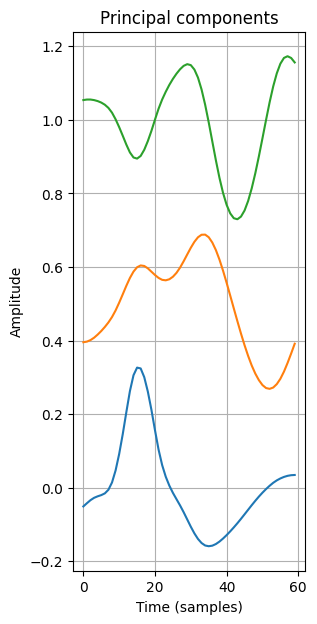

In [24]:
fig, ax = plt.subplots(1,1,figsize=(3,7))
plt.plot(pca.components_.T+np.arange(3)*0.5)
plt.grid(True)
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.title('Principal components')

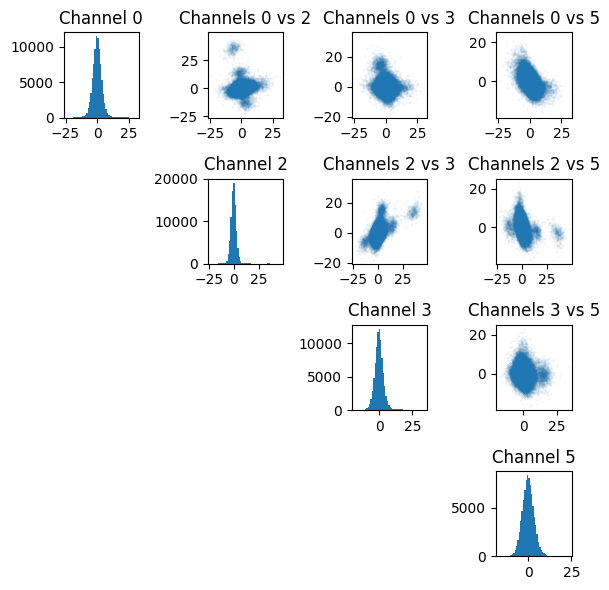

In [25]:
chan_list = [0,2,3,5]
fig, ax = plt.subplots(4,4,figsize=(6,6))
for ind1, chan1 in enumerate(chan_list):
    for ind2, chan2 in enumerate(chan_list):
        if ind1==ind2:
            ax[ind1,ind2].hist(pca_chans[:,0,chan1], bins=50)
            ax[ind1,ind2].set_title('Channel {x}'.format(x=chan1))
        elif ind1>ind2:
            ax[ind1,ind2].axis('off')
        else:
            ax[ind1,ind2].scatter(pca_chans[:,0,chan1],pca_chans[:,0,chan2], alpha=0.1, s=.1)
            ax[ind1,ind2].set_title('Channels {x} vs {y}'.format(x=chan1,y=chan2))

fig.tight_layout()

As with the handcrafted features, we can see that positive and negative peaked spikes are separated (the bimodal distributions seen with many of the components). A few other clusters are evident as well, and they are now slightly more distinct compared with the hand crafted features.

It may be that patterns in the spike waveforms spread across multiple channels may better separate different neurons. To determine this, we can have PCA fit components to the entire spike waveform expressed on all channels.

In [26]:
# collapse channels together
waves_collapse = waves.transpose((0,2,1)).reshape((-1,chan_num*win_num))

# Set PCA parameters
n_comp = 3

# Create PCA object
pca = PCA(n_components=n_comp)

# Apply PCA to each channel separately
pca_pool = pca.fit_transform(waves_collapse)

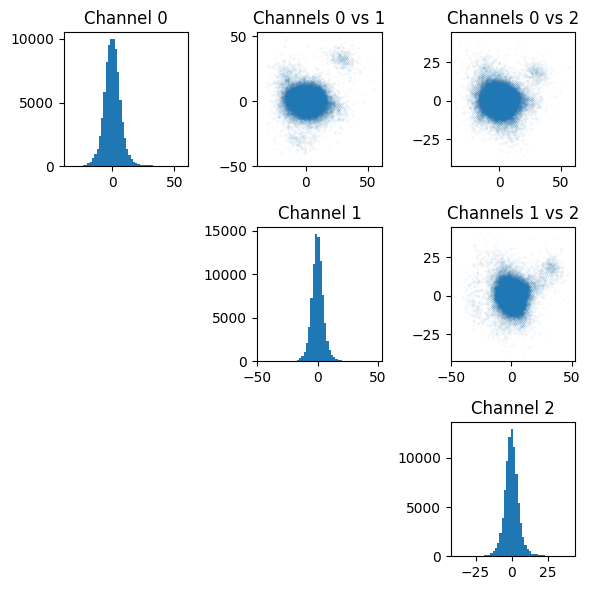

In [27]:
chan_list = [0,1,2]
fig, ax = plt.subplots(3,3,figsize=(6,6))
for ind1, chan1 in enumerate(chan_list):
    for ind2, chan2 in enumerate(chan_list):
        if ind1==ind2:
            ax[ind1,ind2].hist(pca_pool[:,chan1], bins=50)
            ax[ind1,ind2].set_title('Channel {x}'.format(x=chan1))
        elif ind1>ind2:
            ax[ind1,ind2].axis('off')
        else:
            ax[ind1,ind2].scatter(pca_pool[:,chan1],pca_pool[:,chan2], alpha=1, s=.001)
            ax[ind1,ind2].set_title('Channels {x} vs {y}'.format(x=chan1,y=chan2))

fig.tight_layout()

This did not improve our separation much. Indeed, it is not common to apply PCA on waveforms concatenated across channels.

### Clustering of spike groups

Once the spike waveforms have been dimensionally reduced in a way to produce clusters, we can classify individual spikes based on which cluster they most likely below two. There are three often used approaches to this. The first is to draw boundaries around clusters by hand. This *manual* step can either be done as the only approach, or after automated cluster assignment as a way to refine and fix errors in an automated approach. The other two approaches are automated. The second is to find the center (also known as a centroid) of each cluster and assign spikes to whichever center they are closet to. The k-means algorithm does this. A third approach is to fit a collection of gaussian probability distributions to the data, and spikes are assinged guassian they are most likely to belong to.

We will skip the manual step because it is self-explanetory and cumbersome to implement in a Jupyter notebook.

#### K-means

K-means clustering assigns each neuron to a cluster based on its closeness to a center point. This results in cluster boundaries that are straight lines, which may not be advantageous in some cases. The experimenter specifies the number of clusters to be used, and will adjust this based on how well the cluster borders match the distribution of data points evident by eye. Note, however, that automated approaches are available to select the number of clusters.

/Users/drewheadley/anaconda3/envs/decode_brain/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Text(0.5, 1.0, 'K-means clustering')

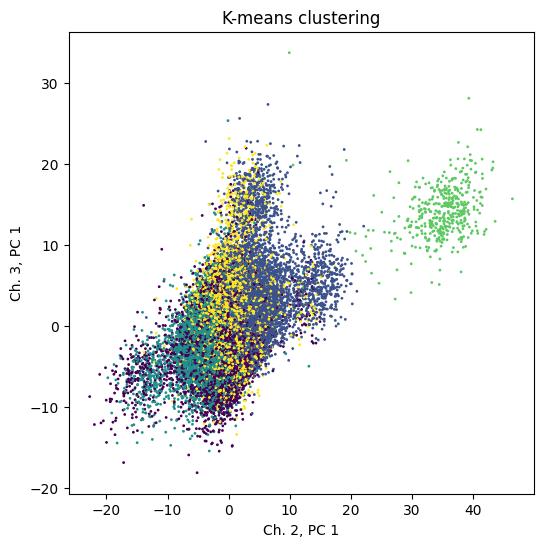

In [29]:
np.random.seed(42)

# collapse channels together
pca_chans_flat = pca_chans.reshape((-1,chan_num*n_comp))

# k-means clustering parameters
n_clus = 5

# fit k-means
km = KMeans(n_clus)
clus_km = km.fit(pca_chans_flat).labels_

# plot clusters
fig, ax = plt.subplots(1,1,figsize=(6,6))
plt.scatter(pca_chans[:,0,2],pca_chans[:,0,3], c=clus_km, s=1)
plt.xlabel('Ch. 2, PC 1')
plt.ylabel('Ch. 3, PC 1')
plt.title('K-means clustering')

Here we have a scatter plot of principal components for two channels, with each spike colored by the cluster it was assigned to. We can see that the k-means clustering algorithm has divided up the spikes into groups that in general map on to this view of the PC space. But some clusters that seem distinct have been merged together, such as two blobs that make up the light green cluster. The solution to this is to increase the number of clusters for k-means to identify.

/Users/drewheadley/anaconda3/envs/decode_brain/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Text(0.5, 1.0, 'K-means clustering')

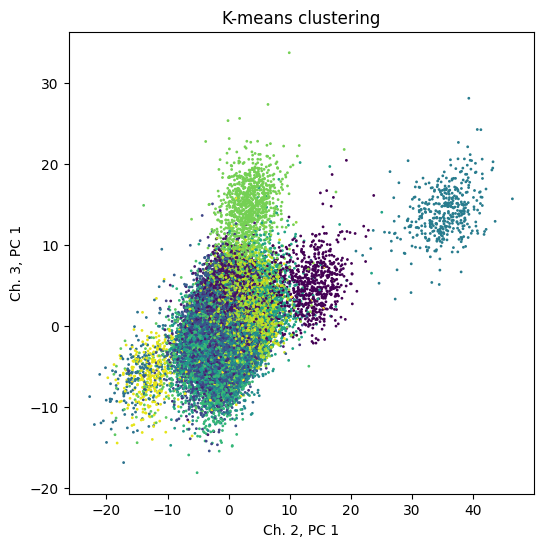

In [47]:
np.random.seed(5)

# collapse channels together
pca_chans_flat = pca_chans.reshape((-1,chan_num*n_comp))

# k-means clustering parameters
n_clus = 25

# fit k-means
km = KMeans(n_clus)
clus_km = km.fit(pca_chans_flat).labels_

# plot clusters
fig, ax = plt.subplots(1,1,figsize=(6,6))
plt.scatter(pca_chans[:,0,2],pca_chans[:,0,3], c=clus_km, s=1)
plt.xlabel('Ch. 2, PC 1')
plt.ylabel('Ch. 3, PC 1')
plt.title('K-means clustering')

That seems to have worked, with the former light green cluster now split in two. A side effect, though, of increasing the number of clusters is that we now have many clusters overlapping or in close proximity to each each. It seems as if the algorithm has taken single clusters of data points and split them into multiple groups. This is known as *overclustering* or *oversplitting* and is faily common in spike sorting. The reason is that it is easier for the person analyzing the data to combine clusters back together than to identify when a cluster has to be split. Often they are looking at the mean spike waveform for each cluster which makes any similar looking spike clusters readily apparent. Moreover, they cannot visualize all principal component axes (24 in this case) simultaneously to appreicate when a split is required.

To organize this data, the spike waveforms, cluster id, and spike times, we will place it into a pandas dataframe.

In [48]:
# create a dictionary where each key is a cluster and each value is a list of spike times
spk_dict = {sel_clus: spks[np.where(clus_km==sel_clus)[0]] for sel_clus in np.unique(clus_km)}

# create dataframe from dictionary where each row is a cluster and each column the np.array of spike times
spk_df = pd.Series(spk_dict).to_frame('times')
spk_df.index.name = 'id'

# add waveform column to dataframe, which is the average waveform for each cluster
wave_func = lambda x: waves[np.where(np.in1d(spks,x))[0],:,:].mean(axis=0) # in1d finds indices of values in x that are also in spks
spk_df['waveform'] = spk_df['times'].apply(wave_func)

# convert spike times to seconds, assuming 30kHz sampling rate
spk_df['times'] = spk_df['times']/30000

Now let's examine the mean spike waveforms to see if any clusters need to be merged.

(0.0, 1750.0)

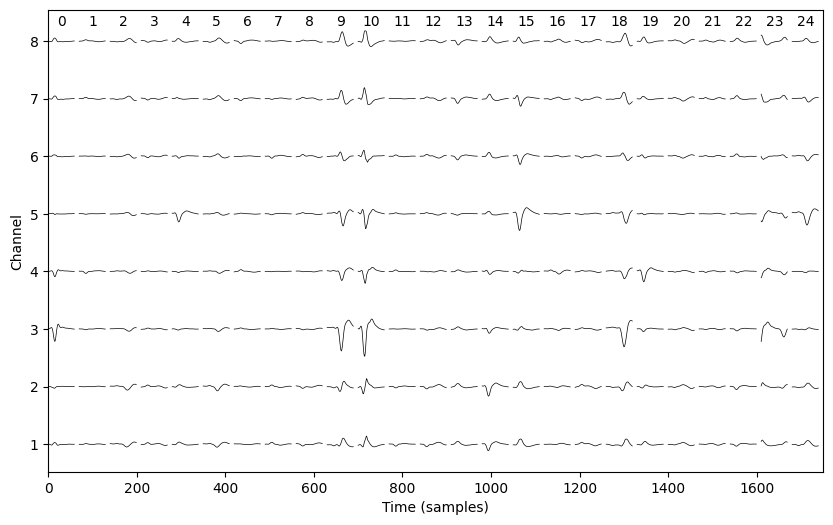

In [49]:
def PlotSpikeWavesDF(df, win=[0,60], x_offset=0, ax=None, **kwargs):
    """
    Plots spike waveforms from a dataframe

    Parameters
    ----------
    df : pandas dataframe
        The dataframe containing spike waveforms
    win : list, optional
        The window to plot, in samples. Format: [start, end]
    x_offset : float, optional
        The offset to add to the x-axis
    ax : matplotlib axis, optional
        The axis to plot on
    kwargs : dict, optional
        Keyword arguments to pass to matplotlib

    Returns
    -------
    ax : matplotlib axis
        The axis that was plotted on
    """

    if ax is None:
        ax = plt.gca()

    for ind, (idx, cols) in enumerate(df.iterrows()):
        SnipPlot(cols['waveform'], win=win, ax=ax, x_offset=x_offset+ind*70, **kwargs)
        ax.text(x_offset+ind*70+30, 220, str(idx), horizontalalignment='center', 
                verticalalignment='center', fontsize=10)
    return ax

# plot mean waveforms
fig, ax = plt.subplots(1,1,figsize=(10,6))
PlotSpikeWavesDF(spk_df, win=[0,60], ax=ax, color='k')
ax.grid(False)
ax.set_xlim([0, 70*spk_df.shape[0]])

Visual inspection indicates that not all the units identified are worth keeping. The ones we want to keep will have a strong spike waveform on at least one channel that is near the center of the waveform (not on the edge), which are 0, 4, 9, 11, 12, and 14. These we will label as tentative single units. We can see some weak spikes present on channels 5, 6, 7, 8, and 16. Combining these together will give us a pool of multiunit activity. Waveforms without a spike waveform or whose waveform is offset from the center will be discarded as noise, which are 1, 2, 3, 10, 13, 15, 17, 18, 19.

Plotting these together as groups might make these differences more apparent.

In [50]:
sua = [0, 4, 10, 14, 15, 19]
mua = [1, 5, 12, 13]
noise = [2, 3, 6, 7, 8, 9, 11, 16, 17, 18, 20, 21, 22, 23, 24]

spk_df['type'] = ''
spk_df['type'].iloc[sua] = 'SU'
spk_df['type'].iloc[mua] = 'MU'
spk_df['type'].iloc[noise] = 'N'

(0.0, 1750.0)

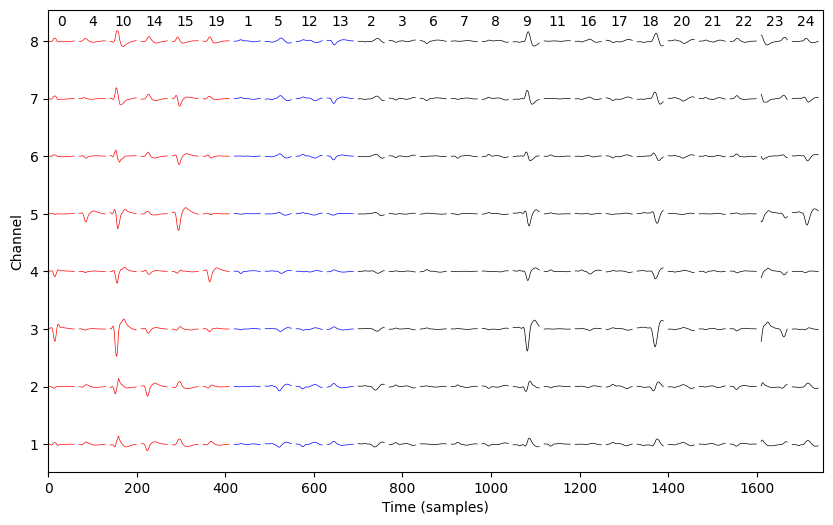

In [51]:
# plot mean waveforms
fig, ax = plt.subplots(1,1,figsize=(10,6))
x_offset = 0
PlotSpikeWavesDF(spk_df[spk_df['type']=='SU'], win=[0,60], ax=ax, color='r')
x_offset = x_offset + len(sua)*70
PlotSpikeWavesDF(spk_df[spk_df['type']=='MU'], win=[0,60], x_offset=x_offset, ax=ax, color='b')
x_offset = x_offset + len(mua)*70
PlotSpikeWavesDF(spk_df[spk_df['type']=='N'], win=[0,60], x_offset=x_offset, ax=ax, color='k')
ax.grid(False)
ax.set_xlim([0, 70*spk_df.shape[0]])

The single units in red have large distinctive spike waveforms that vary across channels. This is less so for multiunit activity, in blue, whose waveforms are much weaker and can be homogenously distributed across channels. Lastly, the noise units in black lack a well defined spike waveform or are secondary detections for an already detected single unit. These will be excluded from further analysis. These likely reflect spurious detections that are not spikes.

## Quality control of spike clusters 
Once single units are identified, we must determine which ones meet the criteria for corresponding to an individual neuron. Several metrics are used, some based on the properties of the spike times, and others on the shape of the extracellular spike waveform. One can also examine the likelihood that two single units will be confused with each other. A good paper covering suggested standards for spike quality metrics is [here](https://www.jneurosci.org/content/31/24/8699).

To examine spike quality metrics, we will load data from the [Allen Institute Visual Coding dataset](https://portal.brain-map.org/explore/circuits/visual-coding-neuropixels). These recordings were made with Neuropixel electrodes inserted into multiple visual processing areas in mice while they watched various visual stimuli. Single units were isolated using the Kilosort algorithm, which uses *matching pursuit* to simulataneously detect and sort units. While it is a bit beyond the scope of this course, if you are curious how that works check out the [Jupyter notebook I made on it for a seminar](https://github.com/dbheadley/SpikeSortShortCourse/blob/main/Code/MPandSVDDemos.ipynb).

The Allen data does not give us the raw extracellular signal, so we will be working with the spike times and amplitudes from already sorted single units. 

### Loading the Allen data

The Allen Institute provides an API for accessing their data sets. To use it, you have to add the AllenSDK to your Python environment. From there, you import the portion of it that handles the Neuropixel visual coding recordings. We did that during our import block above by calling `from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache`. When we call the `EcephysProjectCache` a directory is created on our computer that houses all the data from the Allen Institute that we choose to access.

In [162]:
# File path for the downloaded data cache
allen_dir = '../data/spike_allen2/'
manifest_path = os.path.join(allen_dir,'manifest.json')

# Initialize the data cache
cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

This creates the directory where we will store the data and a manifest.json file that will specify the location and formatting of the data that can be stored locally. Since we will be working with unit activity, we will load a dataframe of all the units that are present in this dataset.

In [163]:
# get units
units = cache.get_units()

units.head()

Each row of the `units` dataframe corresponds to a different unit, indexed by the units id number. For each unit we have:
1. Quality metrics: amplitude_cutoff, isi_violations, etc
2. General properties: firing_rate, waveform_halfwidth, etc
3. Session information: date_of_acquisition, session_type, etc
4. Subject information: age_in_days, sex, etc 

This data is stored on the hard drive in the units.csv file in our cache directory. In addition, we have CSV files for Neuropixel probes used to  record (probes.csv), their electrodes (channels.csv), and the recording sessions (sessions.csv). 

In [173]:
sessions

,published_at,specimen_id,session_type,age_in_days,sex,full_genotype,unit_count,channel_count,probe_count,ecephys_structure_acronyms
id,,,,,,,,,,
715093703,2019-10-03T00:00:00Z,699733581,brain_observatory_1.1,118.0,M,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,884,2219,6,"[CA1, VISrl, nan, PO, LP, LGd, CA3, DG, VISl, ..."
719161530,2019-10-03T00:00:00Z,703279284,brain_observatory_1.1,122.0,M,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,755,2214,6,"[TH, Eth, APN, POL, LP, DG, CA1, VISpm, nan, N..."
721123822,2019-10-03T00:00:00Z,707296982,brain_observatory_1.1,125.0,M,Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,444,2229,6,"[MB, SCig, PPT, NOT, DG, CA1, VISam, nan, LP, ..."
732592105,2019-10-03T00:00:00Z,717038288,brain_observatory_1.1,100.0,M,wt/wt,824,1847,5,"[grey, VISpm, nan, VISp, VISl, VISal, VISrl]"
737581020,2019-10-03T00:00:00Z,718643567,brain_observatory_1.1,108.0,M,wt/wt,568,2218,6,"[grey, VISmma, nan, VISpm, VISp, VISl, VISrl]"
739448407,2019-10-03T00:00:00Z,716813543,brain_observatory_1.1,112.0,M,wt/wt,625,2221,6,"[grey, VISam, nan, VIS, VISp, VISl, VISrl]"
742951821,2019-10-03T00:00:00Z,723627604,brain_observatory_1.1,120.0,M,wt/wt,893,2219,6,"[VISal, nan, grey, VISl, VISrl, VISp, VISpm, VIS]"
743475441,2019-10-03T00:00:00Z,722882755,brain_observatory_1.1,121.0,M,wt/wt,553,2225,6,"[LP, LGd, HPF, DG, CA3, CA1, VISrl, nan, PP, P..."
744228101,2019-10-03T00:00:00Z,719817805,brain_observatory_1.1,122.0,M,wt/wt,659,2226,6,"[Eth, TH, LP, POL, APN, DG, CA1, VIS, nan, CA3..."


### Recording efficacy
Before evaluating the quality of single units, we should determine if the recording they are derived from is good. Specifically, we want to identify periods where there is no spiking across all recorded units. Such an occurrence suggests that a disconnection or disruption of the recording system occurred.

In [53]:
# get columns of units table
print('Units table column names\n{}'.format(units.columns))

# get index of units table
print('Units table index names\n{}'.format(units.index))

Units table column names
Index(['waveform_PT_ratio', 'waveform_amplitude', 'amplitude_cutoff',
       'cumulative_drift', 'd_prime', 'waveform_duration',
       'ecephys_channel_id', 'firing_rate', 'waveform_halfwidth',
       'isi_violations', 'isolation_distance', 'L_ratio', 'max_drift',
       'nn_hit_rate', 'nn_miss_rate', 'presence_ratio',
       'waveform_recovery_slope', 'waveform_repolarization_slope',
       'silhouette_score', 'snr', 'waveform_spread', 'waveform_velocity_above',
       'waveform_velocity_below', 'ecephys_probe_id', 'local_index',
       'probe_horizontal_position', 'probe_vertical_position',
       'anterior_posterior_ccf_coordinate', 'dorsal_ventral_ccf_coordinate',
       'left_right_ccf_coordinate', 'ecephys_structure_id',
       'ecephys_structure_acronym', 'ecephys_session_id', 'lfp_sampling_rate',
       'name', 'phase', 'sampling_rate', 'has_lfp_data', 'date_of_acquisition',
       'published_at', 'specimen_id', 'session_type', 'age_in_days', 'sex',
  

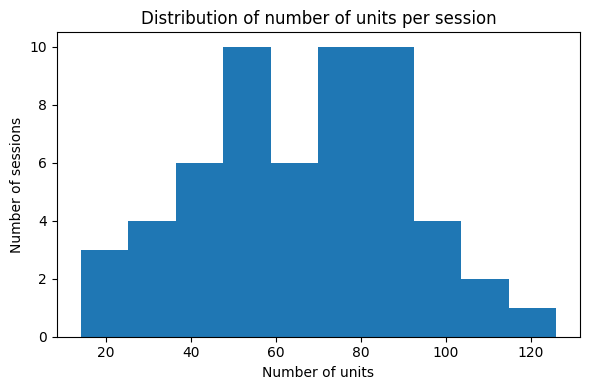

In [54]:
# select only those units recorded in primary visual cortex
visp_units = units[units['ecephys_structure_acronym']=='VISp']

# get number of units recorded in VISp for each session
num_units = visp_units.groupby('ecephys_session_id').size()

fig, ax = plt.subplots(1,1,figsize=(6,4))
ax.hist(num_units, bins=10)
ax.set_xlabel('Number of units')
ax.set_ylabel('Number of sessions')
ax.set_title('Distribution of number of units per session')
fig.tight_layout()

In [55]:
# get session ID with most units
sess_id = num_units[num_units==num_units.max()].index.values[0]

print('Session ID with most units: {x}'.format(x=sess_id))

Session ID with most units: 779839471


In [56]:
sess = cache.get_session_data(721123822)

/Users/drewheadley/anaconda3/envs/decode_brain/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Users/drewheadley/anaconda3/envs/decode_brain/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.6.0-alpha is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


In [57]:
units_visp = sess.units[sess.units['ecephys_structure_acronym']=='VISp']
unit_ids_visp = units_visp.index.values

/Users/drewheadley/anaconda3/envs/decode_brain/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Users/drewheadley/anaconda3/envs/decode_brain/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.6.0-alpha is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Users/drewheadley/anaconda3/envs/decode_brain/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Users/drewheadley/anaconda3/envs/decode_brain/lib/python3.9/site-packages/hdmf/spec/namespace.py:531

In [58]:
units_visp.head()

,waveform_PT_ratio,waveform_amplitude,amplitude_cutoff,cluster_id,cumulative_drift,d_prime,firing_rate,isi_violations,isolation_distance,L_ratio,...,ecephys_structure_id,ecephys_structure_acronym,anterior_posterior_ccf_coordinate,dorsal_ventral_ccf_coordinate,left_right_ccf_coordinate,probe_description,location,probe_sampling_rate,probe_lfp_sampling_rate,probe_has_lfp_data
unit_id,,,,,,,,,,,,,,,,,,,,,
950908795,0.421037,124.905690,0.001842,309,136.79,3.597608,1.558922,0.298691,40.292643,0.029793,...,385.0,VISp,8566.0,1375.0,8023.0,probeC,See electrode locations,29999.999795,1249.999991,True
950908404,0.421819,33.738900,0.020126,188,263.77,2.560206,3.527604,0.153507,44.373622,0.046168,...,385.0,VISp,8563.0,1386.0,8023.0,probeC,See electrode locations,29999.999795,1249.999991,True
950908410,0.734521,57.176340,0.000492,191,143.59,4.283679,21.928571,0.001907,113.004473,0.007690,...,385.0,VISp,8570.0,1364.0,8024.0,probeC,See electrode locations,29999.999795,1249.999991,True
950908418,0.588709,66.980745,0.010223,195,222.05,2.630567,3.994343,0.023946,45.615850,0.025208,...,385.0,VISp,8582.0,1331.0,8026.0,probeC,See electrode locations,29999.999795,1249.999991,True
950908416,0.587100,63.149385,0.026651,194,320.46,2.097244,3.421291,0.388405,40.302663,0.040834,...,385.0,VISp,8582.0,1331.0,8026.0,probeC,See electrode locations,29999.999795,1249.999991,True


In [59]:
# get all spike times in a session
spike_times = sess.spike_times

# Create a dataframe from dictionary of spike_times and restrict to units in VISp
spikes_visp = pd.Series(spike_times) # convert to series
spikes_visp.index.name = 'unit_id' # name the index column
spikes_visp.name = 'times' # name the data column
spikes_visp = spikes_visp.to_frame() # convert to dataframe
spikes_visp = spikes_visp.loc[unit_ids_visp] # restrict to units in VISp

/Users/drewheadley/anaconda3/envs/decode_brain/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Users/drewheadley/anaconda3/envs/decode_brain/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.6.0-alpha is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Users/drewheadley/anaconda3/envs/decode_brain/lib/python3.9/site-packages/allensdk/brain_observatory/ecephys/ecephys_session.py:1371: UserWarning: Session includes invalid time intervals that could be accessed with the attribute 'invalid_times',Spikes within these intervals are invalid and may need to be excluded from the analysis.
  warnings.warn("Session includes invalid time intervals that coul

In [60]:
spikes_all = np.sort(np.hstack(spikes_visp['times'].values))

# print session duration based on spike times
print('Session duration: {x:.2f} minutes'.format(x=spikes_all[-1]/60))

Session duration: 163.52 minutes


To get the number of spikes every second, we have to use a binning function. Binning divides up time into evenly spaced intervals and counts the number of events that occured in each interval. We will write our own function to do this.

Text(0.5, 1.0, 'Spike count histogram')

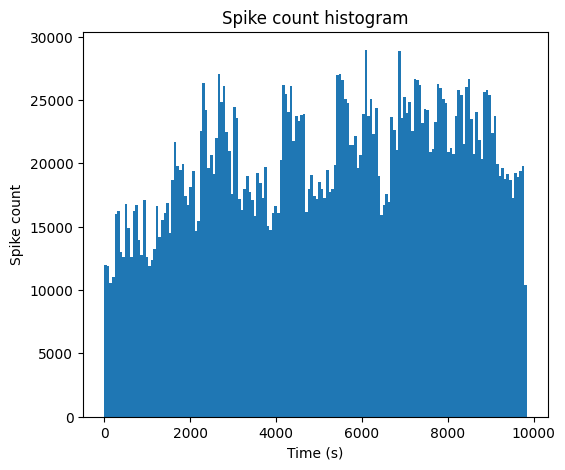

In [71]:
def bin_pts(x, bin_dur=1, win=None):
    """
    Bins a list of time points

    Parameters
    ----------
    x : array
        The time points to bin
    bin_dur : float
        The duration of each bin
    win : list, optional
        The window to bin, in samples. Format: [start, end]

    Returns
    -------
    bin_vals : array
        The binned values
    bin_edges : array
        The edges of the bins
    """

    # if no window is specified, use the min and max of the data points
    if win is None:
        win = [x.min(), x.max()]
    
    # create bins
    bin_edges = np.arange(win[0],win[1]+bin_dur,bin_dur)
    bin_vals = np.zeros(bin_edges.size-1)

    # iterate through bins and count number of points in each bin
    for ind in range(bin_vals.size):
        bin_vals[ind] = np.sum((x>=bin_edges[ind])&(x<bin_edges[ind+1]))

    return bin_vals, bin_edges

bin_dur = 60 # second bin

# bin spikes using our function
bin_spks, bin_edges = bin_pts(spikes_all, bin_dur=bin_dur)

fig, ax = plt.subplots(1,1,figsize=(6,5))
ax.bar(bin_edges[:-1], bin_spks, width=bin_dur, align='edge')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Spike count')
ax.set_title('Spike count histogram')

For the ~2.7 hours of the recording, there is no time that was free of spiking. This indicates that our recording was free of the most severe of disruptions, a disconnection of the amplifier.

Text(0.5, 1.0, 'Spike count histogram')

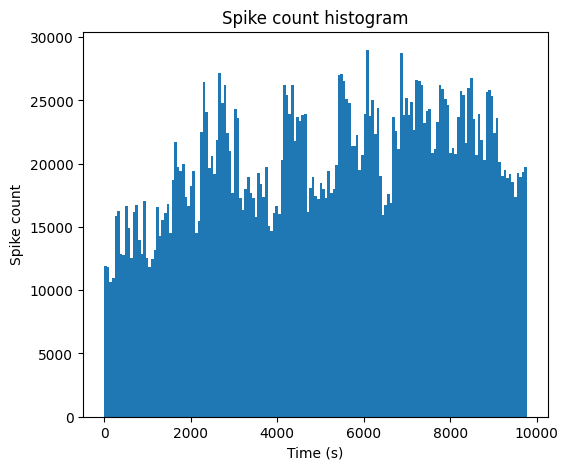

In [73]:
bins = np.arange(0,spikes_all[-1],bin_dur)
bin_spks, bin_edges = np.histogram(spikes_all, bins=bins)

fig, ax = plt.subplots(1,1,figsize=(6,5))
ax.bar(bin_edges[:-1], bin_spks, width=bin_dur, align='edge')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Spike count')
ax.set_title('Spike count histogram')

### Firing rate
Each class of neurons in a given brain region has a characteristic distribution of mean firing rates. The firing rate is the number of spikes emitted by a neuron per a unit of time. To get the mean firing rate, we often count the total number of spikes emitted by a unit during the session and divide by the duration of that session in seconds.

$$
\text{FR} = \frac{\text{Number of spikes}}{\text{Session duration}}
$$

Let's calculate the mean firing rate for single units in primary visual cortex.

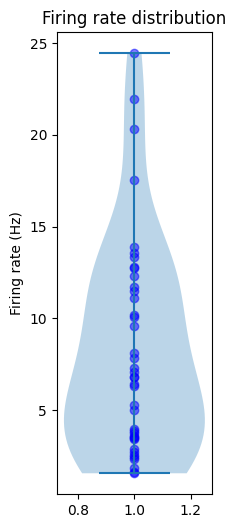

In [75]:
sess_dur = spikes_all[-1]-spikes_all[0]

# function for caluclating firing rate
fr_func = lambda x: x.size/sess_dur

# calculate firing rate
spikes_visp['mean_fr'] = spikes_visp['times'].apply(fr_func)

fr = spikes_visp['mean_fr'].values


# plot mean firing rate
# Plotting the distribution of firing rates
fig, ax = plt.subplots(1,1,figsize=(2,6))
ax.violinplot(fr)
ax.scatter(np.ones(fr.size),fr, color='b', alpha=0.5)
ax.set_ylabel('Firing rate (Hz)')
ax.set_title('Firing rate distribution')
plt.show()

Units had broad range of firing rates. Generally these are around 5 Hz in cortex. If single unit has a firing rate above 10 Hz, there is a good chance it is an *interneuron*, which is a type of neuron that only sends its projections locally and is almost always inhibitory (silences the neurons near it).

While this dataset excludes noise and multiunit activity, it is worth know how their firing rates will differ from those of single units. Single unit's firing rate exceeds 20 Hz, it is possibly comprised of multiple neurons whose spikes were grouped together. Single unit's with firing rates below 0.1 Hz may have too few spikes for subsequent analyses. Noise units show a great deal of variability, reflecting the variety of nonspiking circumstances that can generate them, ranging from a fraction of a hertz to hundred of hertz. High frequency electronic noise or EMG activity can produce very high firing rates, while a rarely occuring artifact produces exceptionally low firing rates. Multiunit activity will tend to have a firing around above 20 Hz, but this varies greatly by region and how many single units are contributing to the multiunit.

When evaluating the quality of our unit acitivity, we want to ensure that our single units generally have lower firing rates than multiunits, and both have a tigher distribution of rates than noise units.

### Inter-spike interval distribution
Besides their mean firing rates, single neurons also exhibit characteristic distributions in the time intervals between their spikes. These are referred to as inter-spike interval (ISI) distributions. They tend to be log-normal, and sometimes exhibit multiple peaks indicating different firing modes, such as bursting.

Since neurons have an absolute refractory period, there should be a paucity of ISIs with lags on the order of a few milliseconds. We can check for this by finding the ISI below which only 5% of spikes occurred. The higher this number is, the more likely we are dealing with a single neuron. If our spikes are multiunit, then there will not be a prominent refractory period because the neurons generally fire independently on a 

In [76]:
# ISI distribution
def isi_dist_calc(spks):
    isi_bins = np.logspace(-5,0.5,100,base=10) # log intervals because ISIs are long-tailed
    hist_data = np.histogram(np.diff(spks),isi_bins) 
    return hist_data

# calculate ISI distribution for each unit
spikes_visp['isi'] = spikes_visp['times'].apply(isi_dist_calc)


# ISI below which 5% of spikes occurred
def isi_coff_func(isi_data):
    isi_cp = np.cumsum(isi_data[0])/np.sum(isi_data[0])
    isi_cutoff = isi_data[1][np.nonzero((isi_cp)>0.05)[0][0]]
    return isi_cutoff

# calculate ISI cutoff for each unit
spikes_visp['isi_cutoff'] = spikes_visp['isi'].apply(isi_coff_func)

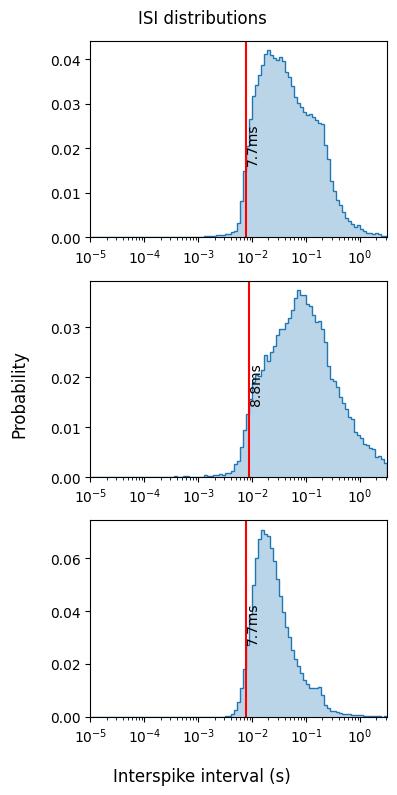

In [77]:
unit1 = spikes_visp.index.values[6]
unit2 = spikes_visp.index.values[1]
unit3 = spikes_visp.index.values[2]

# plots ISI distrbution along with 5% cutoff
def isi_plot(isi_dist, isi_cutoff, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
        
    # find the time when more than 0.5% of ISIs remain
    isi_prob = isi_dist[0]/np.sum(isi_dist[0])
    ax.stairs(isi_prob, isi_dist[1], fill=True, alpha=0.3)
    ax.stairs(isi_prob, isi_dist[1], color='tab:blue')
    ax.set_xscale('log')

    ax.set_xlim(isi_dist[1][[0,-1]])
    ax.axvline(isi_cutoff,color='r')
    ax.text(isi_cutoff, np.max(isi_prob)/2,'{:2.1f}ms'.format(isi_cutoff*1000),rotation=90,verticalalignment='center') 
    return ax

fig, ax = plt.subplots(3,1, figsize=(4,8))
isi_plot(spikes_visp.loc[unit1,'isi'],spikes_visp.loc[unit1,'isi_cutoff'],ax=ax[0])
isi_plot(spikes_visp.loc[unit2,'isi'],spikes_visp.loc[unit2,'isi_cutoff'],ax=ax[1])
isi_plot(spikes_visp.loc[unit3,'isi'],spikes_visp.loc[unit3,'isi_cutoff'],ax=ax[2])
fig.supylabel('Probability')
fig.supxlabel('Interspike interval (s)')
fig.suptitle('ISI distributions')
fig.tight_layout()
plt.show()

The single unit has 5% of its ISIs less than ~7 ms, while the multiunit and noise examples are less than 1 ms. Even though the multiunit activity is composed of mulitple single units, each with their own refractory period, their firing is not correlated on the timescale of milliseconds so while one neuron is in a refractory state another can fire. This leads to multiunit activity tending to have more spikes separated by an interval smaller than the refractory period. Noise units, on the other hand, do not have a refractory period since their source is presumably not neural.

Let's look at the distribuion of ISI cutoffs across all unit types to see if these observations generalize.

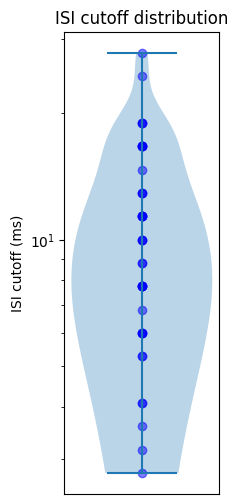

In [78]:
# group ISI cutoff for each unit type
cutoffs = spikes_visp['isi_cutoff'].values*1000

# plot mean firing rate
# Plotting the distribution of firing rates
fig, ax = plt.subplots(1,1,figsize=(2,6))
ax.violinplot(cutoffs)
ax.scatter(np.ones(cutoffs.shape),cutoffs, color='b', alpha=0.5)
ax.set_ylabel('ISI cutoff (ms)')
ax.set_yscale('log')
ax.set_xticks([])
ax.set_title('ISI cutoff distribution')
plt.show()


As we can see, most of the cutoffs are above 3 ms. This puts them outside the refractory period of a single neuron. On the other hand, multiunit activity that is the aggregated activity of multiple single units then it would not show a cessation of the spiking during the refractory period. This is because when any one neuron is in its refractory period following an action potential another neuron could spike. We will attempt to measure this with the next metric, the *false positive rate*.

### False positive rate
We can further exploit the refractory period by measuring the degree to which spikes violate it. This can be formalized as a ratio of the rate of observed violations over the predicated rate of violations from a unit with the same firing rate but no refractory period. The higher this value is, the less likely the single unit reflects an individual neuron. A typical cutoff is 0.5, meaning that the number of violations are half of what would be expected from a unit with no refractory period.

Below is a function for calculating this. We set the refractory period to 3 ms.

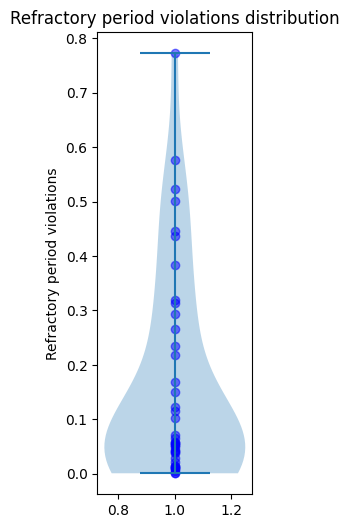

In [79]:
def refract_fp(spks):
    refract = 0.003 # setting refractory period
    num_spks = spks.size
    dur = spks[-1]-spks[0] # total duration of spiking
    viol_count = np.sum(np.diff(spks)<=refract) # number of refractory period violations
    refract_time = 2*refract*num_spks # total potential time for refractory period violations
    spk_rate = num_spks/dur # mean firing rate, irrespective of refractory period
    viol_rate = viol_count/refract_time # firing rate just during the refractory period
    r_fp = viol_rate/spk_rate # ratio of observed to predicted violations
    return r_fp

# calculate refractory period violations for each unit
spikes_visp['fp_rate'] = spikes_visp['times'].apply(refract_fp)

# plot distribution of refractory period violations
fp_rate = spikes_visp['fp_rate'].values

fig, ax = plt.subplots(1,1,figsize=(2,6))
ax.violinplot(fp_rate)
ax.scatter(np.ones(fp_rate.size),fp_rate, color='b', alpha=0.5)
ax.set_ylabel('Refractory period violations')
ax.set_title('Refractory period violations distribution')
plt.show()


In the Allen Insitute data, the cutoff for false positive rate considered acceptable for single units is 0.5. Most of the single units in our data set fall within this criterion.

### Spike amplitude
The amplitude of a spike is related to the morphology of the neuron it originates from and its distance from the recording electrode. Generally, the farther a neuron's soma is from the electrode, the smaller its spike waveform amplitude. Larger neurons with most of their dendrites directed in a specific direction (e.g. layer 5 pyramidal neurons) will also produce larger amplitudes. Since a neuron's action potential tends to have a consistent amplitude, the extracellular spike it generates will also be consistent and should show a distribution that is normal. Exceptions to this are neurons that fire bursts of action potentials just a few milliseconds apart, with spikes later in the burst having a lower amplitude (and if a cell is bursting that can be seen in the ISI plots).

The smaller a single unit's spike waveform amplitude, the harder it is to reliably seperate from the background noise of the recording. When performing spike detection we set a threshold for detecting a spike, and this is based on our estimate of the background level. If the spike waveform amplitude is close to the background level of the signal, then there will be many missed detections because the amplitude failed to cross our threshold. These false negatives will show up as a truncation of the normal distribution of amplitudes on the low amplitude side of the curve. We can measure the degree to which this is a problem by fitting a normal curve to the distribution of amplitudes, and then measuring the 

In [80]:
spk_amps = pd.Series(sess.spike_amplitudes)
spk_amps.index.name = 'unit_id'
spk_amps.name = 'amplitude'

spikes_visp = spikes_visp.join(spk_amps)

/Users/drewheadley/anaconda3/envs/decode_brain/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Users/drewheadley/anaconda3/envs/decode_brain/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.6.0-alpha is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


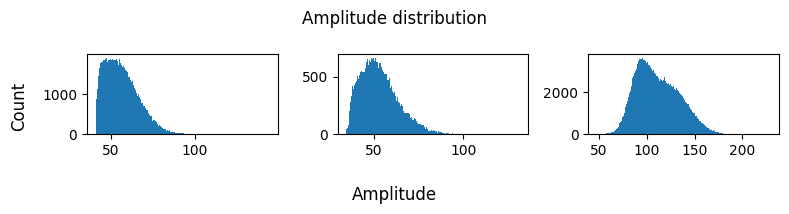

In [81]:
unit1 = spikes_visp.index.values[6]
fig, ax = plt.subplots(1,3, figsize=(8,2))
ax[0].hist(spikes_visp.loc[unit1,'amplitude']*1e6, bins=200)
ax[1].hist(spikes_visp.loc[unit2,'amplitude']*1e6, bins=200)
ax[2].hist(spikes_visp.loc[unit3,'amplitude']*1e6, bins=200)
fig.supylabel('Count')
fig.supxlabel('Amplitude')
fig.suptitle('Amplitude distribution')
fig.tight_layout()
plt.show()

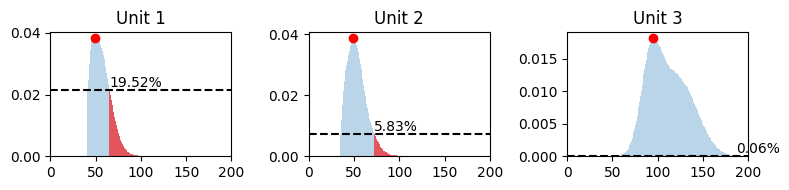

In [91]:
# based the algorithm from the Allen Institute spike quality metrics code
# which is based on a measure proposed in Hill et al. 2011 J Neurosci 31: 8699-8705
def amp_cutoff(amps, ax=None):
    '''
    Calculates the amplitude cutoff for a given unit

    Parameters
    ----------
    amps : array
        The spike amplitudes for a unit
    ax : matplotlib axis, optional
        The axis to plot on

    Returns
    -------
    miss_prob : float
        The probability that a spike will be missed due to amplitude cutoff
    '''
    dist, bins = np.histogram(amps, bins=200, density=True)
    dist = gaussian_filter1d(dist, 3) # smooth the distribution
    peak_idx = np.argmax(dist) # find the peak

    # find the first point in the distribution above the peak that
    # falls below the probability density for the lowest amplitude.
    # If the true distribution of spike amplitudes is symmetric, then
    # then the area under from this point to the maximum amplitude should
    # be equal to the 
    g = np.argmin(np.abs(dist[peak_idx:]-dist[0]))+peak_idx

    # calculate the area under the curve from the end of the distribution
    # since the values are probability density, each bin must be multiplied
    # by the bin size to get absolute probability
    bin_size = np.mean(np.diff(bins)) # calculate bin size
    miss_prob = bin_size*np.sum(dist[g:]) # calculate area under the curve from the end of the distribution

    # have max_prob cutoff at 0.5
    miss_prob = np.min([miss_prob, 0.5])
    # if axes are provided, plot the distribution and the cutoff
    if ax is not None:
        ax.stairs(dist, bins, fill=True, alpha=0.3)
        ax.axhline(dist[0], color='k', linestyle='--')
        ax.stairs(dist[g:], bins[g:], fill=True, alpha=0.6, color='r')
        ax.scatter(bins[peak_idx], dist[peak_idx], color='r')
        ax.text(bins[g], dist[g], '{:.2f}%'.format(miss_prob*100), verticalalignment='bottom')
    
    return miss_prob

fig, ax = plt.subplots(1,3, figsize=(8,2))
amp_cutoff(spikes_visp.loc[unit1,'amplitude']*1e6, ax=ax[0])
ax[0].set_xlim([0, 200])
ax[0].set_title('Unit 1')   
amp_cutoff(spikes_visp.loc[unit2,'amplitude']*1e6, ax=ax[1])
ax[1].set_xlim([0, 200])
ax[1].set_title('Unit 2')
amp_cutoff(spikes_visp.loc[unit3,'amplitude']*1e6, ax=ax[2])
ax[2].set_xlim([0, 200])
ax[2].set_title('Unit 3')
fig.tight_layout()


Here we can see that Unit 1 has a sharp cutoff in its distribution on the low amplitude end, indicating that its spike waveform was just above the threshold for detection. Consequently, it is missing many of its spikes, approximately 20%, assuming that the distribution of amplitudes is symmetrical. Unit 2 has less of a truncation problem, but is still missing 5% of spikes. By contrast, Unit 3 has virtually no truncation. Note that its amplitudes is higher in general, peaking around 100, which is souble that for Unit 1 and Unit 2. In all likelihood, Unit 3 was closer to the recording electrode, giving it a larger extracellular spike waveform and thus better isolation from the background.

In [186]:
spk_waves = pd.Series(sess.mean_waveforms)
spk_waves.index.name = 'unit_id'
spk_waves.name = 'waveform'

spikes_visp = spikes_visp.join(spk_waves)

spikes_visp['waveform'] = spikes_visp['waveform'].apply(np.array)
# # get the spike waveform from the electrode where it was strongest
# spk_pwaves = spks.get_info('peak_wave')
# spk_amps = spk_pwaves.apply(lambda x: np.max(np.abs(x)))
# spk_amps.index.name = 'clu_id'
# spk_amps.name = 'amp'
# print('Spike waveform amplitudes:\n{}'.format(spk_amps))

/Users/drewheadley/anaconda3/envs/decode_brain/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Users/drewheadley/anaconda3/envs/decode_brain/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.6.0-alpha is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


In [187]:
np.array(spikes_visp.loc[950908795,'waveform'])

array([[ 0.      ,  0.129675, -0.240825, ...,  0.701805,  1.486095,
         1.957995],
       [ 0.      ,  0.227565,  0.18447 , ...,  2.0163  ,  1.52217 ,
         1.679925],
       [ 0.      ,  0.02652 , -0.23985 , ...,  0.63687 ,  0.782535,
         0.66261 ],
       ...,
       [ 0.      , -0.421785, -0.301665, ...,  0.450645,  0.103545,
         0.39156 ],
       [ 0.      ,  0.11622 , -0.249795, ...,  1.28037 ,  0.64818 ,
         0.923325],
       [ 0.      ,  0.127335, -0.05109 , ..., -0.213915,  0.022815,
        -0.222885]])

### Waveform

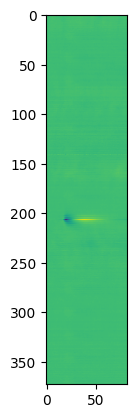

In [191]:
plt.imshow(spikes_visp.loc[950908795, 'waveform'])

## Appendix PCA properties
Fourier components emerge for 'nonsignificant' components. Seems to depend on smoothness of data.

Related to eigen decomposition of toeplitz matrices.

Can lead to spurious results, so be careful: 

https://www.pnas.org/doi/10.1073/pnas.2311420120

https://journals.physiology.org/doi/abs/10.1152/jn.1996.76.6.3823


In [189]:


# Set PCA parameters
n_comp = 20

# Create PCA object
pca = PCA(n_components=n_comp)

# Apply PCA to each channel separately
pca_chans = [pca.fit_transform(x.squeeze()) for x in np.split(waves, chan_num, axis=2)]

# Recombine components across channels
pca_chans = np.stack(pca_chans,axis=2)

NameError: name 'waves' is not defined

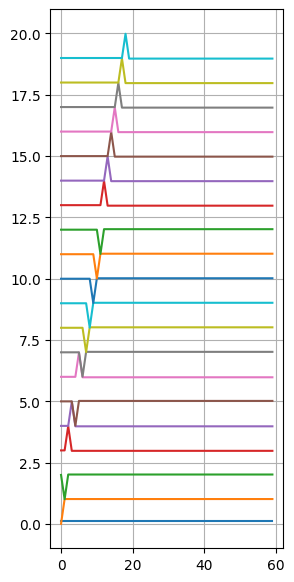

In [ ]:
waves_rand = waves.copy()

for i in range(waves.shape[0]):
    for j in range(waves.shape[2]):
        waves_rand[i,:,j]=np.random.choice(waves[i,:,j])

# Set PCA parameters
n_comp = 20

# Create PCA object
pca = PCA(n_components=n_comp)

# Apply PCA to each channel separately
pca_chans = [pca.fit_transform(x.squeeze()) for x in np.split(waves_rand, chan_num, axis=2)]

# Recombine components across channels
pca_chans = np.stack(pca_chans,axis=2)

fig, ax = plt.subplots(1,1,figsize=(3,7))
plt.plot(pca.components_.T+np.arange(20))
plt.grid(True)

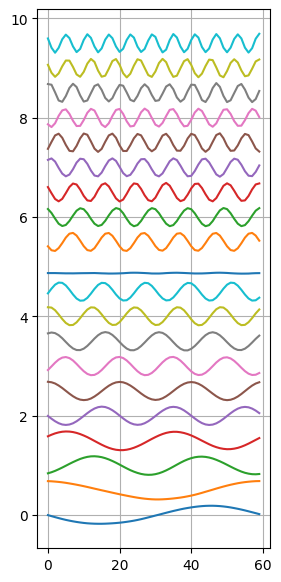

In [ ]:
waves_shift = waves.copy()

for i in range(waves.shape[0]):
    for j in range(waves.shape[2]):
        waves_shift[i,:,j]=np.roll(waves[i,:,j], np.random.choice(waves.shape[1],1))

# Set PCA parameters
n_comp = 20

# Create PCA object
pca = PCA(n_components=n_comp)

# Apply PCA to each channel separately
pca_chans = [pca.fit_transform(x.squeeze()) for x in np.split(waves_shift, chan_num, axis=2)]

# Recombine components across channels
pca_chans = np.stack(pca_chans,axis=2)

fig, ax = plt.subplots(1,1,figsize=(3,7))
plt.plot(pca.components_.T+np.arange(20)*0.5)
plt.grid(True)